# remove create custom Cnn model and just use a regular Sequential()

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

2024-10-13 02:53:13.951015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 02:53:14.069011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 02:53:14.098121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 02:53:14.436848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 02:53:15.637158: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1728780796.915758   23727 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728780797.280157   23727 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728780797.280262   23727 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


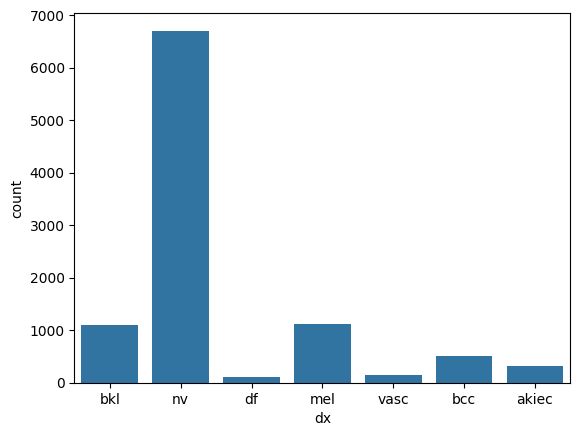

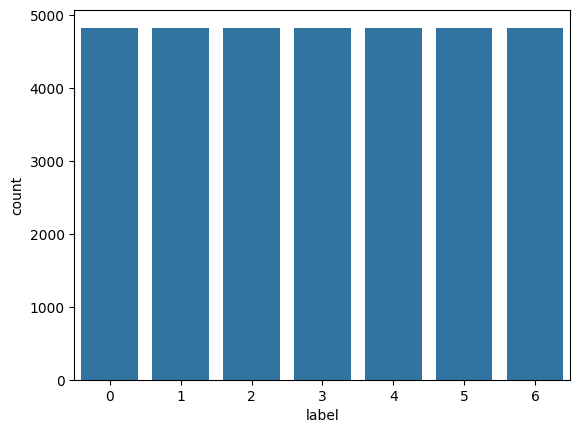

In [3]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.show()

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

from sklearn.utils import resample

df_majority = train_df[train_df['label'] == train_df['label'].value_counts().idxmax()]

df_upsampled = [df_majority]

for label in train_df['label'].unique():
    if label != df_majority['label'].iloc[0]:  
        df_minority = train_df[train_df['label'] == label]
        df_minority_upsampled = resample(df_minority, 
                                         replace=True,    
                                         n_samples=len(df_majority),  
                                         random_state=42)  
        df_upsampled.append(df_minority_upsampled)

train_df_balanced = pd.concat(df_upsampled)

train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='label', data=train_df_balanced)
plt.show()

In [4]:
print(train_df_balanced['label'].unique())  
print(val_df['label'].unique())    
print(test_df['label'].unique())   

[4 5 2 0 1 6 3]
[5 2 1 0 4 3 6]
[5 4 2 1 3 0 6]


In [5]:
train_df_balanced['label'] = train_df_balanced['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


In [6]:
image_size = (64, 64)  
batch_size = 132

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df_balanced,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 33789 validated image filenames belonging to 7 classes.
Found 802 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [7]:
class CustomCNN(models.Model):
    def __init__(self, layers_list):
        super(CustomCNN, self).__init__()
        self.model = models.Sequential()
        for layer in layers_list:
            self.model.add(layer)
    
    def call(self, inputs):
        return self.model(inputs)



In [8]:
len(train_generator)

256

In [12]:
import math

def create_baseline_model(input_shape=(64, 64, 3), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

# Create and evaluate the baseline model
baseline_model = create_baseline_model()

baseline_model.summary()
history = baseline_model.fit(train_generator, validation_data=val_generator, epochs=5, validation_steps=len(val_generator))

# %% Evaluate Baseline Model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 121s 463ms/step - accuracy: 0.3771 - auc: 0.7601 - loss: 1.5688 - val_accuracy: 0.5075 - val_auc: 0.8873 - val_loss: 1.1649
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 119s 464ms/step - accuracy: 0.5569 - auc: 0.8896 - loss: 1.1402
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-13 03:10:58.343819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12125672060241144621
2024-10-13 03:10:58.343867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18368839620207907949


 34/256 ━━━━━━━━━━━━━━━━━━━━ 1:37 440ms/step - accuracy: 0.6223 - auc: 0.9166 - loss: 0.9987

KeyboardInterrupt: 

/home/bosa/manu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.5495 - auc: 0.8968 - loss: 1.1388
Test Accuracy: 0.5506739616394043
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step
ROC AUC Score: 0.5112568334021597
F1 Score: 0.3699784463232151


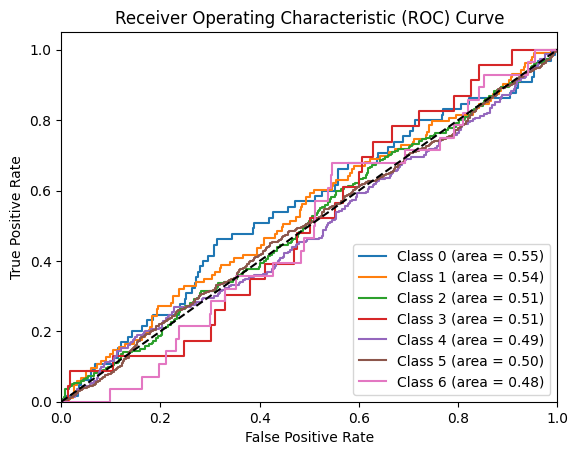

In [9]:
test_results = baseline_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Accuracy: {test_acc}')

y_true = test_generator.classes
y_pred_prob = baseline_model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)

roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

num_classes = len(train_generator.class_indices)  
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
def create_custom_cnn(hp):
    input_shape = (64, 64, 3)
    conv_filters = hp.Int('conv_filters', min_value=32, max_value=256, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    activation = hp.Choice('activation', values=['relu', 'elu'])

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(2 * conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4 * conv_filters, (3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

In [13]:
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(
    create_custom_cnn,
    objective='auc',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='ham10000_tuning_balanced',
)

tuner.search(train_generator, 
             epochs=5,
             validation_data=val_generator,
             validation_steps=len(val_generator))

best_model = tuner.get_best_models(num_models=1)[0]

test_results = best_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Accuracy of Best Model: {test_acc}')

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

Trial 5 Complete [00h 17m 42s]
auc: 0.8943451841672262

Best auc So Far: 0.8943451841672262
Total elapsed time: 01h 28m 26s
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.5354 - auc: 0.8966 - loss: 1.1157
Test Accuracy of Best Model: 0.5476784706115723
{'conv_filters': 64, 'learning_rate': 0.000359715360330316, 'dropout_rate': 0.2, 'activation': 'relu'}


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.6873 - auc: 0.9406 - loss: 0.8457
Test Loss: 0.867489218711853
Test Accuracy: 0.6859710216522217
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step
ROC AUC Score: 0.49520720416714886
F1 Score: 0.5279719228535658


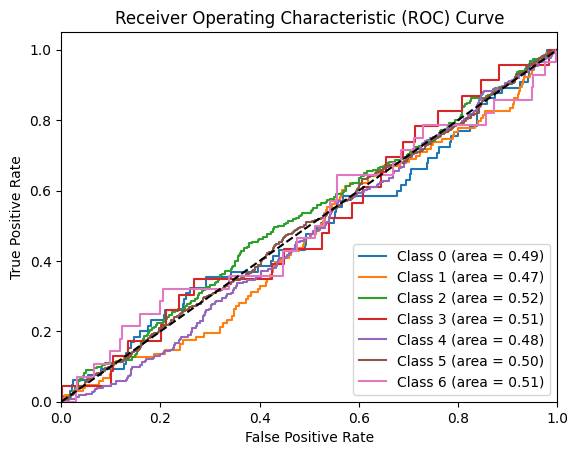

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

test_results = best_model.evaluate(test_generator, steps=len(test_generator))
test_loss, test_acc = test_results[0], test_results[1]
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

y_true = test_generator.classes  
y_pred_prob = best_model.predict(test_generator)  
y_pred = y_pred_prob.argmax(axis=1)  

roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

num_classes = len(train_generator.class_indices) 
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
